In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns

In [3]:
reviews = pd.read_csv('./data/lm_reviews_window_decor.csv', sep=';', encoding='utf-8-sig', parse_dates=['date'], date_format='%d.%m.%y')
footage_production = pd.read_parquet('./data/footage_production.parquet')
fabric_tuples = pd.read_csv('./data/fabric_tuples.csv', sep=';', encoding='utf-8-sig') 
stock = pd.read_csv('./data/stock.csv', sep=';')
fabric = pd.read_parquet('./data/fabric.parquet')
vgames = pd.read_parquet('./data/videogames.parquet')
retail = pd.read_csv('./data/retail_shops.csv', sep=';')

In [4]:
defective_design_list = ['БамбукDAYLIGHT', 'ЗавиткиDAYLIGHT', 'КортезаBLACKOUT', 'ПлайнBLACKOUT', 'СатинBLACKOUT']

defect_design_monthly = footage_production[ 
    (footage_production['period'] >= '2019-01-01') & 
    (footage_production['period'] <= '2020-12-01') & 
    (~footage_production['design'].isna() ) &
    ((footage_production['design']+footage_production['transparency']).isin(defective_design_list))
    ]

defect_design_monthly = defect_design_monthly.pivot_table(index=['period','design','transparency'], values=['defect_m2','produced_m2'], aggfunc='sum').reset_index()

defect_design_monthly['%_of_defect_m2'] = defect_design_monthly['defect_m2'] / defect_design_monthly['produced_m2']
defect_design_monthly['design_tr'] = defect_design_monthly['design'] + ' ' + defect_design_monthly['transparency']

defect_design_monthly['design_tr'] = defect_design_monthly['design_tr'].str.replace('BLACKOUT','BO')
defect_design_monthly['design_tr'] = defect_design_monthly['design_tr'].str.replace('DAYLIGHT','DL')

# Histogram

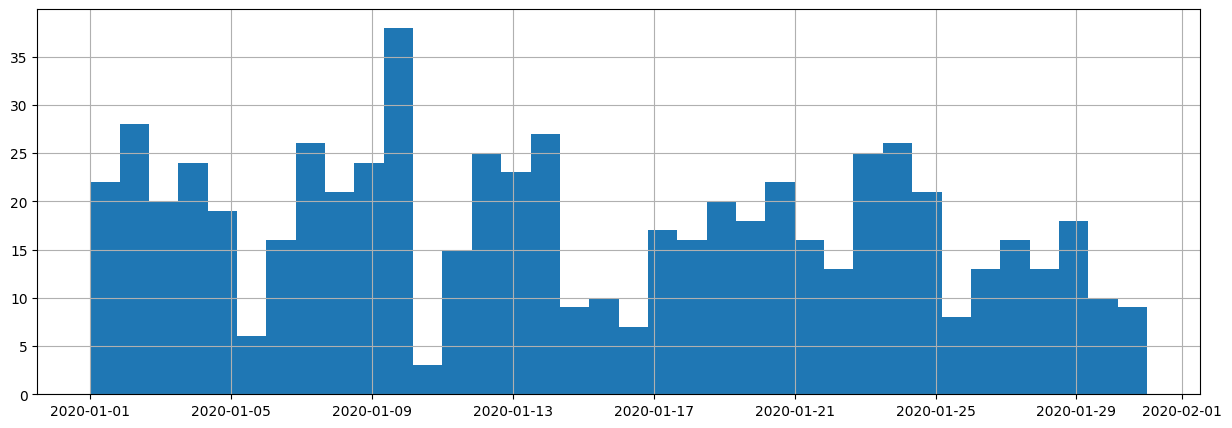

In [5]:
reviews['date'] = pd.to_datetime(reviews['date'], format='%d.%M.%Y')
reviews[ reviews['date'] >= '2020-01-01']['date'].hist(figsize=(15,5), bins=36)
plt.show()

In [6]:
waste_fabric_width_distribution = fabric.pivot_table(index=['period','fabric_name','batch','fabric_width(m)'], columns='cut_status', values='total_footage(m2)', aggfunc='sum')\
    .fillna(0)\
    .reset_index()\
    .sort_values(by='period')\
    .drop(columns=['Брак','Возврат'])\
    .rename(columns={'Отходы':'waste(m2)', 'Производство':'produced(m2)'})

waste_fabric_width_distribution = waste_fabric_width_distribution[ waste_fabric_width_distribution['produced(m2)'] != 0 ]
waste_fabric_width_distribution['%_of_waste(m2)'] = waste_fabric_width_distribution['waste(m2)'] / waste_fabric_width_distribution['produced(m2)'] 

fabric.head(3)

,period,fabric_name,batch,fabric_width(m),fabric_lenght(m),cut_number,cut_width(m),cut_height(m),cut_status,production_name,properties,production_qty,cut_footage(m2),total_footage(m2),individual_production
59924,2020-09-01,Бернаут Завитки белый,00009 (2м),2.0,25.45,2,1.63,0.35,Производство,Рулонная штора Бернаут Завитки Белый 035x160 L...,DEC,1,0.5705,0.5705,False
59925,2020-09-01,Бернаут Завитки белый,00009 (2м),2.0,25.45,1,1.63,0.50,Производство,Рулонная штора Бернаут Завитки Белый 050x160 L...,DEC,2,0.8150,1.6300,False
59926,2020-09-01,Бернаут Завитки белый,00009 (2м),2.0,25.45,1,0.37,0.50,Отходы,none,none,2,0.1850,0.3700,False


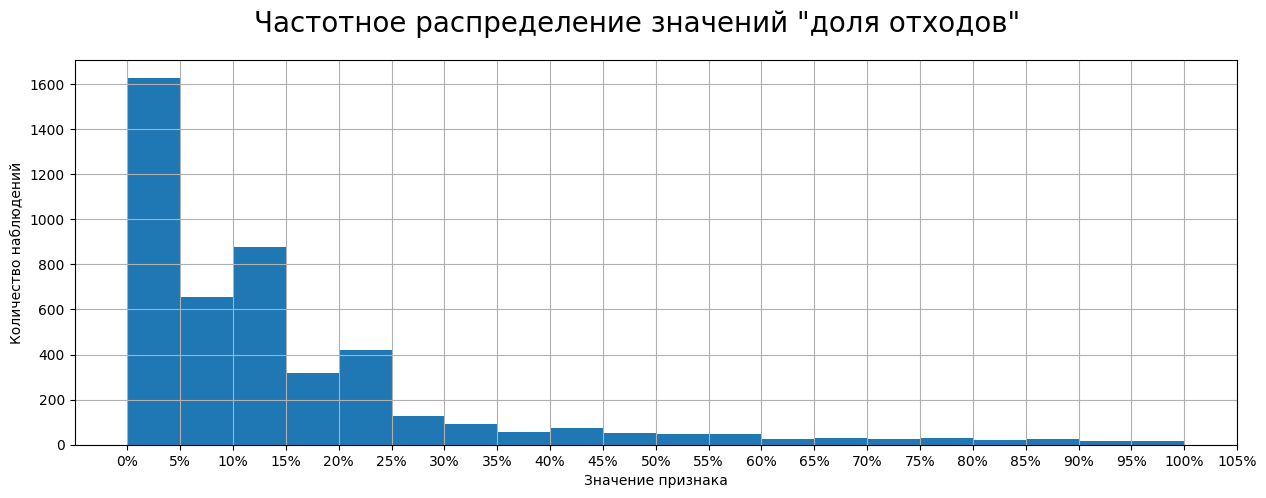

In [7]:
ax = waste_fabric_width_distribution['%_of_waste(m2)'].hist(range=(0,1), figsize=(15,5), bins=20)
plt.xticks(np.arange(0, 1.1, 0.05))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.ylabel('Количество наблюдений')
plt.xlabel('Значение признака')
plt.suptitle('Частотное распределение значений "доля отходов"', fontsize=20)

plt.show()

# Bar plot

In [8]:
rev = reviews.pivot_table(index='category', values='art', aggfunc='count').sort_values(by='art', ascending=False)

rev.head(3)

,art
category,
Готовые шторы и тюли,1249
Рулонные шторы,699
Аксессуары для штор,201


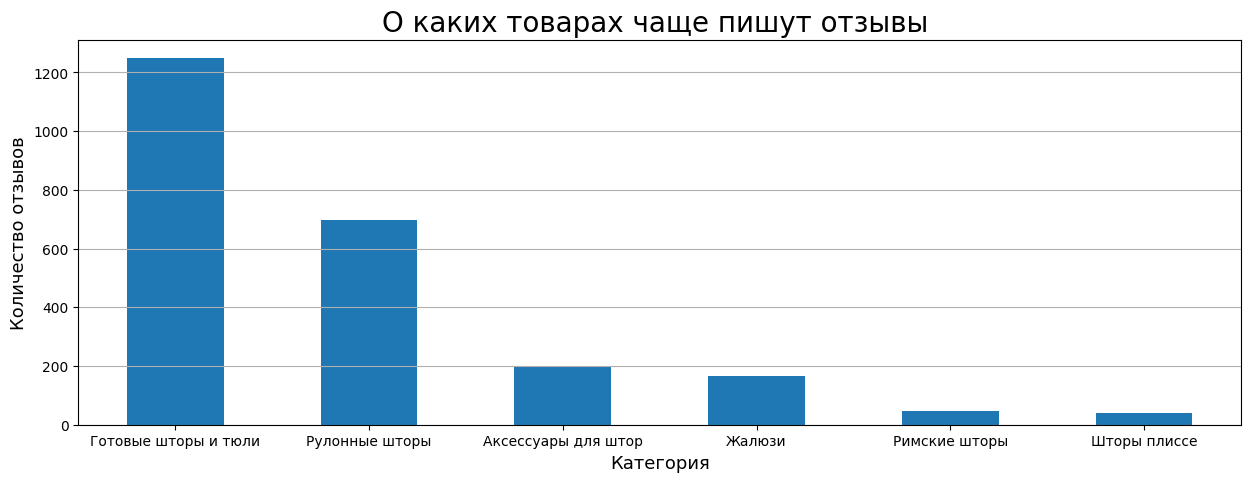

In [9]:
rev.plot.bar(figsize=(15,5), legend=False)

plt.title('О каких товарах чаще пишут отзывы ', fontsize = 20)
plt.xlabel('', fontsize = 13)
plt.ylabel('Количество отзывов', fontsize = 13)
plt.xlabel('Категория', fontsize = 13)
plt.xticks(rotation=0)
plt.grid(axis='y') 
plt.show()

In [10]:
avg_score = (
    reviews.pivot_table(index='category', columns='overal_score', values='art', aggfunc='count')
        .fillna(0)
        .transpose()
        .apply(lambda x:100 * x / float(x.sum())).round(2) # перевод значений в проценты
        .transpose()
    )

avg_score.head(3)

overal_score,1,2,3,4,5
category,,,,,
Аксессуары для штор,19.40,3.98,6.97,11.94,57.71
Готовые шторы и тюли,6.41,3.36,5.68,13.21,71.34
Жалюзи,6.67,3.64,4.85,12.12,72.73


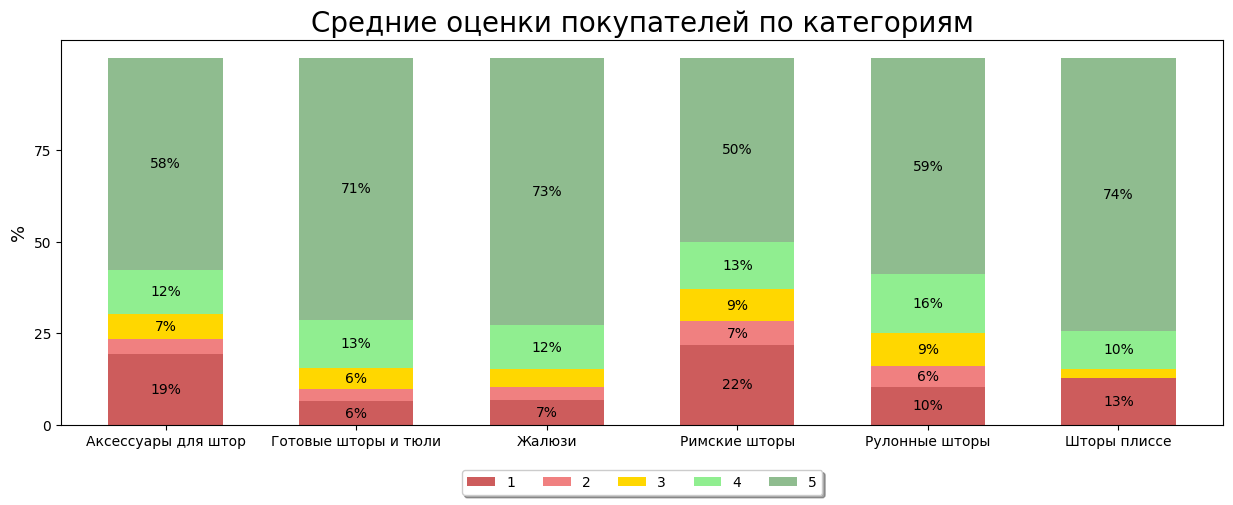

In [11]:
ax = avg_score.plot.bar(figsize=(15,5), stacked=True, width=0.6, color=['indianred', 'lightcoral','gold', 'lightgreen','darkseagreen'])
plt.title('Средние оценки покупателей по категориям', fontsize = 20)
plt.ylabel('%', fontsize = 13)
plt.xlabel('', fontsize = 13)
plt.legend(loc='lower center', fancybox=True, shadow=True, ncol=5, bbox_to_anchor=(0.5, -0.20))
plt.yticks(np.arange(0, 100, 25))
plt.xticks(rotation=0)

# показать подписи
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 5:
        ax.text(x+width/2, 
            y+height/2, 
            '{:.0f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

plt.show()


In [12]:
defect_year = footage_production.copy()
defect_year['year'] = pd.to_datetime(defect_year['period']).dt.year
defect_year = defect_year.pivot_table(index='year', values=['defect_m2','produced_m2','defect_rub'], aggfunc='sum')
defect_year['%_of_defect'] = defect_year['defect_m2'] / defect_year['produced_m2']

defect_year.head(3)

,defect_m2,defect_rub,produced_m2,%_of_defect
year,,,,
2017,6136.75581,1.003043e+06,321081.89691,0.019113
2018,13767.94712,1.753234e+06,201919.22076,0.068185
2019,15321.18264,1.973049e+06,238623.19671,0.064207


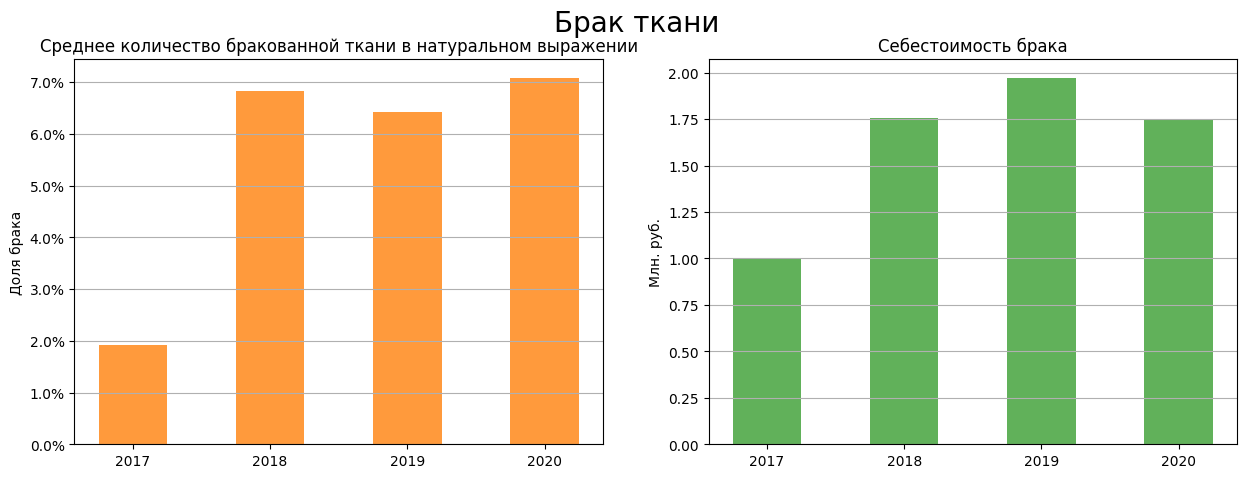

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)

fig.set_figwidth(15)
fig.set_figheight(5)
wid=0.5

axes[0].bar(x=defect_year.index, height=defect_year['%_of_defect'], color='#ff9a3c', width=wid)
axes[0].set_title('Среднее количество бракованной ткани в натуральном выражении')
axes[0].set_xlabel('')
axes[0].set_ylabel('Доля брака')
axes[0].grid(axis='y')
axes[0].ticklabel_format(axis='y', useOffset=False)
axes[0].set_xticks(ticks=defect_year.index,minor=False)
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))


axes[1].bar(x=defect_year.index, height=defect_year['defect_rub']/1000000, color='#61b15a', width=wid)
axes[1].set_title('Себестоимость брака')
axes[1].set_xlabel('')
axes[1].set_ylabel('Млн. руб.')
axes[1].grid(axis='y')
axes[1].set_xticks(ticks=defect_year.index,minor=False)
#axes[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%4.0f'))

plt.suptitle('Брак ткани', fontsize=20)
plt.show()

In [14]:
defect_fabric_type = footage_production[ (footage_production['period'] >= '2019-01-01') & (footage_production['period'] <= '2020-12-01') & (~footage_production['fabric_type'].isna()) ]\
        .pivot_table(index=['fabric_type','transparency'], values=['defect_rub','produced_rub'], aggfunc='sum')\
        .reset_index()

defect_fabric_type['%_of_defect_m2'] = defect_fabric_type['defect_rub'] / defect_fabric_type['produced_rub']

defect_fabric_type = pd.concat([defect_fabric_type, pd.DataFrame([['Бернаут','BLACKOUT']], columns=['fabric_type','transparency'])], ignore_index=True)
defect_fabric_type = defect_fabric_type.sort_values(by=['fabric_type','transparency'], ascending=False)

defect_fabric_type.head(3)

,fabric_type,transparency,defect_rub,produced_rub,%_of_defect_m2
6,Принт,DAYLIGHT,438474.831681,6.334919e+06,0.069216
5,Принт,BLACKOUT,194526.021934,1.631594e+06,0.119224
4,Однотонный,DAYLIGHT,279484.848193,2.339305e+06,0.119473


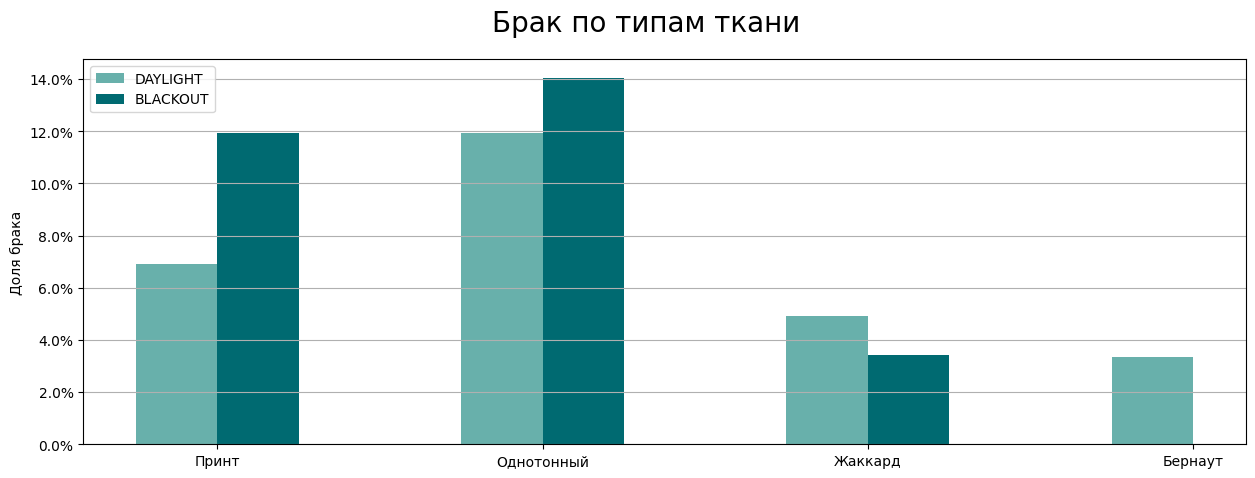

In [15]:
fig, ax = plt.subplots()

fig.set_figwidth(15)
fig.set_figheight(5)

x = np.arange(len( defect_fabric_type['fabric_type'].unique() ) )
width = 0.25

rects1 = ax.bar(
    x=x-width/2, 
    height=defect_fabric_type[ defect_fabric_type['transparency'] == 'DAYLIGHT' ]['%_of_defect_m2'], 
    width=width,
    color='#68b0ab',
    label='DAYLIGHT'
    )

rects2 = ax.bar(
    x=x + width/2, 
    height=defect_fabric_type[ defect_fabric_type['transparency'] == 'BLACKOUT' ]['%_of_defect_m2'], 
    width=width,
    color='#006a71',
    label='BLACKOUT'
    )

ax.yaxis.set_major_formatter( mtick.PercentFormatter(xmax=1) )
ax.set_xticks(x)
ax.set_xticklabels( defect_fabric_type['fabric_type'].unique() )
plt.grid(axis='y')

ax.set_ylabel('Доля брака')
plt.suptitle('Брак по типам ткани', fontsize=20)

ax.legend()
plt.show()

In [16]:
defect_design_monthly1 = defect_design_monthly[(defect_design_monthly['period'] >= '2020-01-01') & (defect_design_monthly['design_tr'].isin(['Завитки DL','Кортеза BO']))].pivot_table(index='period', values='produced_m2', aggfunc='sum', columns='design_tr').fillna(0)
defect_design_monthly1.head(3)

design_tr,Завитки DL,Кортеза BO
period,,
2020-01-01,21.45134,6.4332
2020-02-01,14.72100,0.0000
2020-03-01,15.22435,56.9920


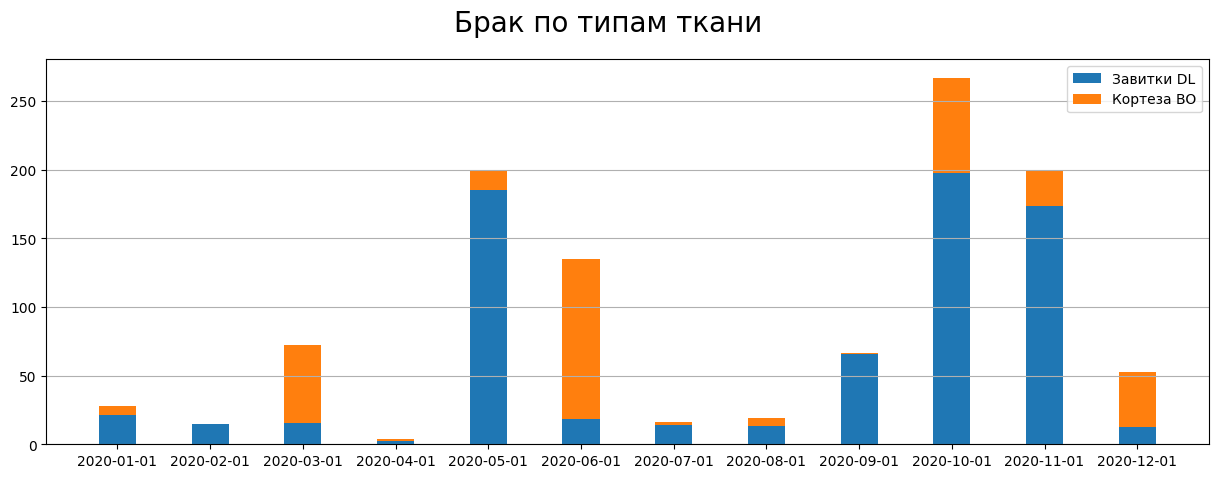

In [17]:
fig, ax = plt.subplots()

fig.set_figwidth(15)
fig.set_figheight(5)

width = 0.4

ax.bar(
    x=defect_design_monthly1.index, 
    height=defect_design_monthly1[defect_design_monthly1.columns[0]], 
    width=width,
    label=defect_design_monthly1.columns[0]
    )

ax.bar(
    x=defect_design_monthly1.index, 
    height=defect_design_monthly1[defect_design_monthly1.columns[1]], 
    width=width,
    label=defect_design_monthly1.columns[1],
    bottom=defect_design_monthly1[defect_design_monthly1.columns[0]]
    )

plt.grid(axis='y')

plt.suptitle('Брак по типам ткани', fontsize=20)
plt.legend()
plt.show()

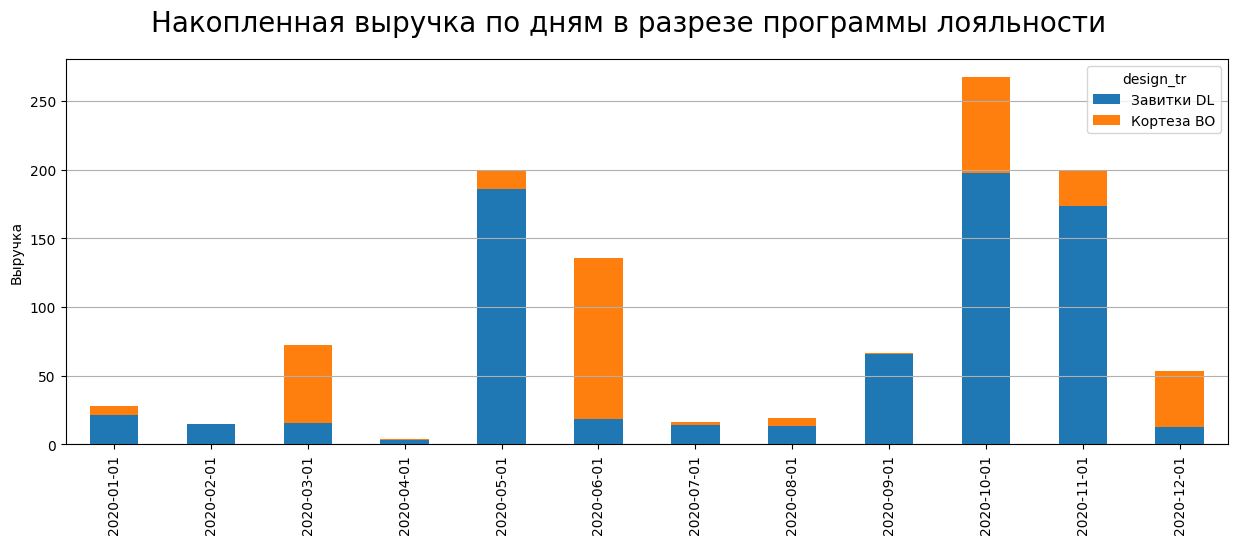

In [18]:
defect_design_monthly1[[defect_design_monthly1.columns[0],defect_design_monthly1.columns[1]]].plot.bar(figsize=(15,5), stacked=True, tick_label=('q') )
plt.suptitle('Накопленная выручка по дням в разрезе программы лояльности', fontsize=20)
plt.ylabel('Выручка')
plt.xlabel('')
plt.grid(axis='y')
plt.show()

In [19]:
retail.head(3)

,shop_id,revenue
0,Shop 0,1120673.89
1,Shop 3,97302.60
2,Shop 6,56738.87


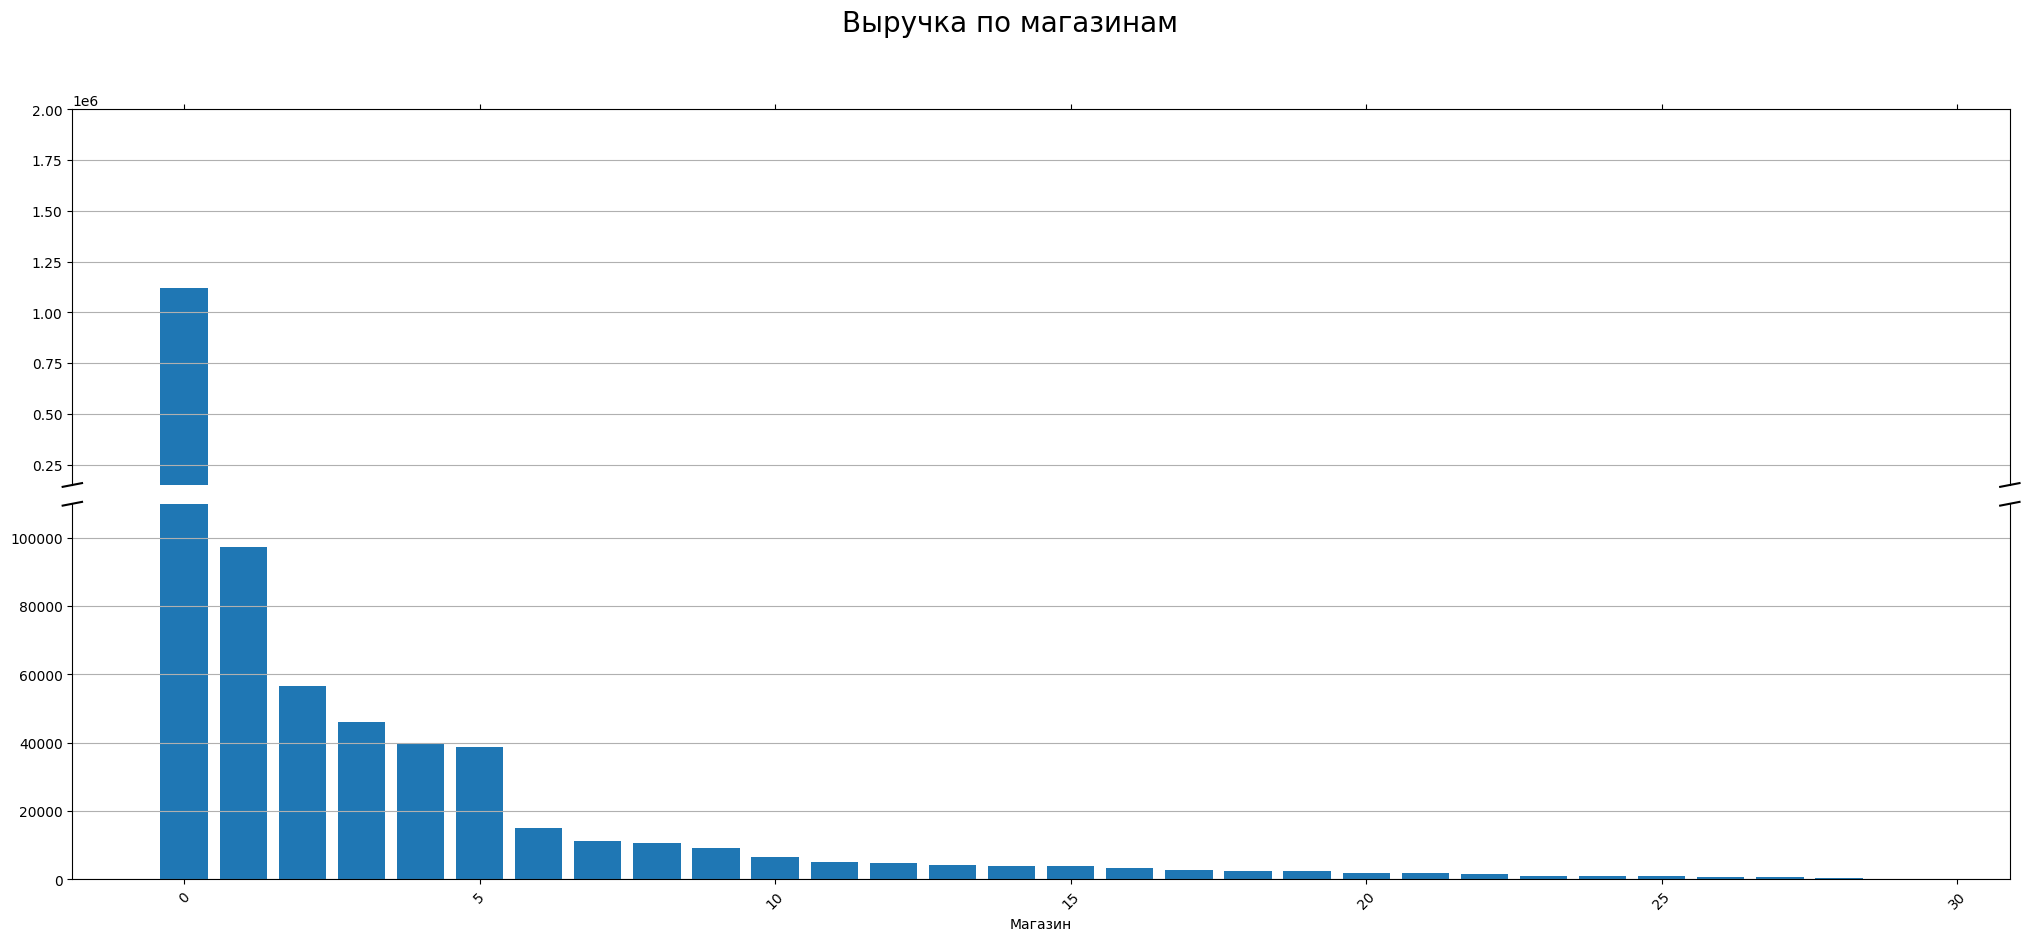

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

fig.set_figwidth(25)
fig.set_figheight(10)

min_main = 0
max_main = 110000
min_outlier = 150000
max_outlier = 2000000

plt.suptitle('Выручка по магазинам', fontsize=20)
plt.xlabel('Магазин')
plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.05) # величина разрыва оси
ax1.grid(axis='y')
ax2.grid(axis='y')

ax1.bar(retail.index, retail['revenue'])
ax2.bar(retail.index, retail['revenue'])

ax1.set_ylim(min_outlier, max_outlier)  # выброс
ax2.set_ylim(min_main, max_main) #основной график

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
#ax1.tick_params(labeltop='off')  
ax2.xaxis.tick_bottom()

d = .005  # ширина скосов

kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.show()

In [21]:
defect_design = footage_production[ (footage_production['period'] >= '2019-01-01') & (footage_production['period'] <= '2020-12-01') & (~footage_production['design'].isna()) ]\
    .pivot_table(index=['design','transparency'], values=['defect_m2','produced_m2'], aggfunc='sum' )\
    .reset_index()

defect_design['%_of_defect_m2'] = defect_design['defect_m2'] / defect_design['produced_m2']
defect_design = defect_design.sort_values(by='%_of_defect_m2', ascending=False)

defect_design.loc[ defect_design['transparency'].str.contains('BLACKOUT', case=False), 'transparency'] = 'BO'
defect_design.loc[ defect_design['transparency'].str.contains('DAYLIGHT', case=False), 'transparency'] = 'DL'

defect_design['design_tr'] = defect_design['design'] + ' ' + defect_design['transparency']

defect_design.loc[ defect_design['transparency'].str.contains('BO', case=False), 'transparency'] = 'BLACKOUT'
defect_design.loc[ defect_design['transparency'].str.contains('DL', case=False), 'transparency'] = 'DAYLIGHT'

defect_design.head(3)

,design,transparency,defect_m2,produced_m2,%_of_defect_m2,design_tr
20,Принт (РФ),BLACKOUT,368.19665,895.093150,0.411350,Принт (РФ) BO
4,Бамбук,DAYLIGHT,1053.65980,2821.079960,0.373495,Бамбук DL
9,Кортеза,BLACKOUT,122.63960,595.526303,0.205935,Кортеза BO


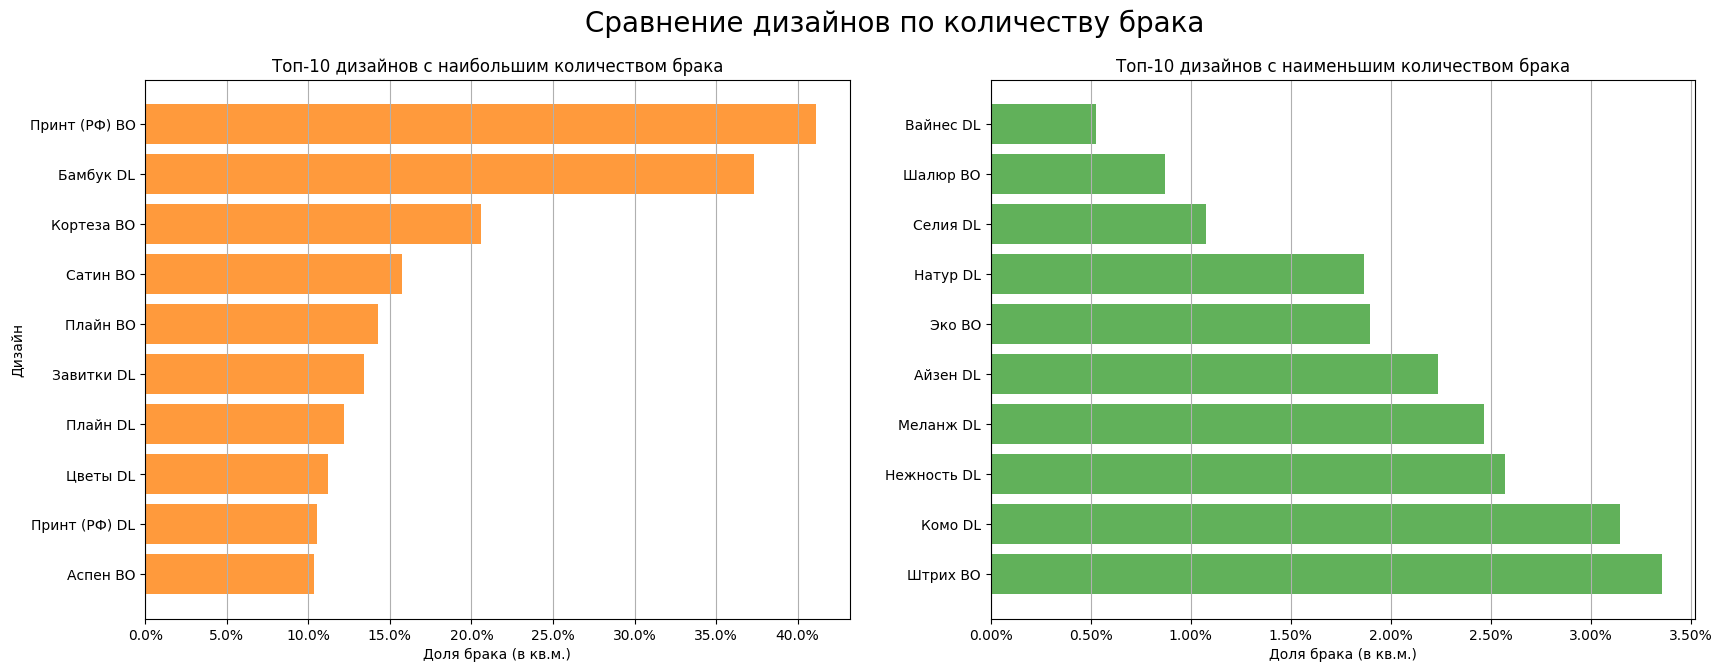

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2)

fig.set_figwidth(20)
fig.set_figheight(7)
wid=0.5


axes[0].barh(
    y=defect_design['design_tr'].head(10), 
    width=defect_design['%_of_defect_m2'].head(10), 
    color='#ff9a3c'
    )
axes[0].set_title('Топ-10 дизайнов с наибольшим количеством брака')
axes[0].set_xlabel('Доля брака (в кв.м.)')
axes[0].set_ylabel('Дизайн')
axes[0].grid(axis='x')
axes[0].invert_yaxis() # обратная сортировка
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))


axes[1].barh(
    y=defect_design['design_tr'].tail(10), 
    width=defect_design['%_of_defect_m2'].tail(10), 
    color='#61b15a'
    )
axes[1].set_title('Топ-10 дизайнов с наименьшим количеством брака')
axes[1].set_xlabel('Доля брака (в кв.м.)')
axes[1].grid(axis='x')
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.suptitle('Сравнение дизайнов по количеству брака', fontsize=20)
plt.show()

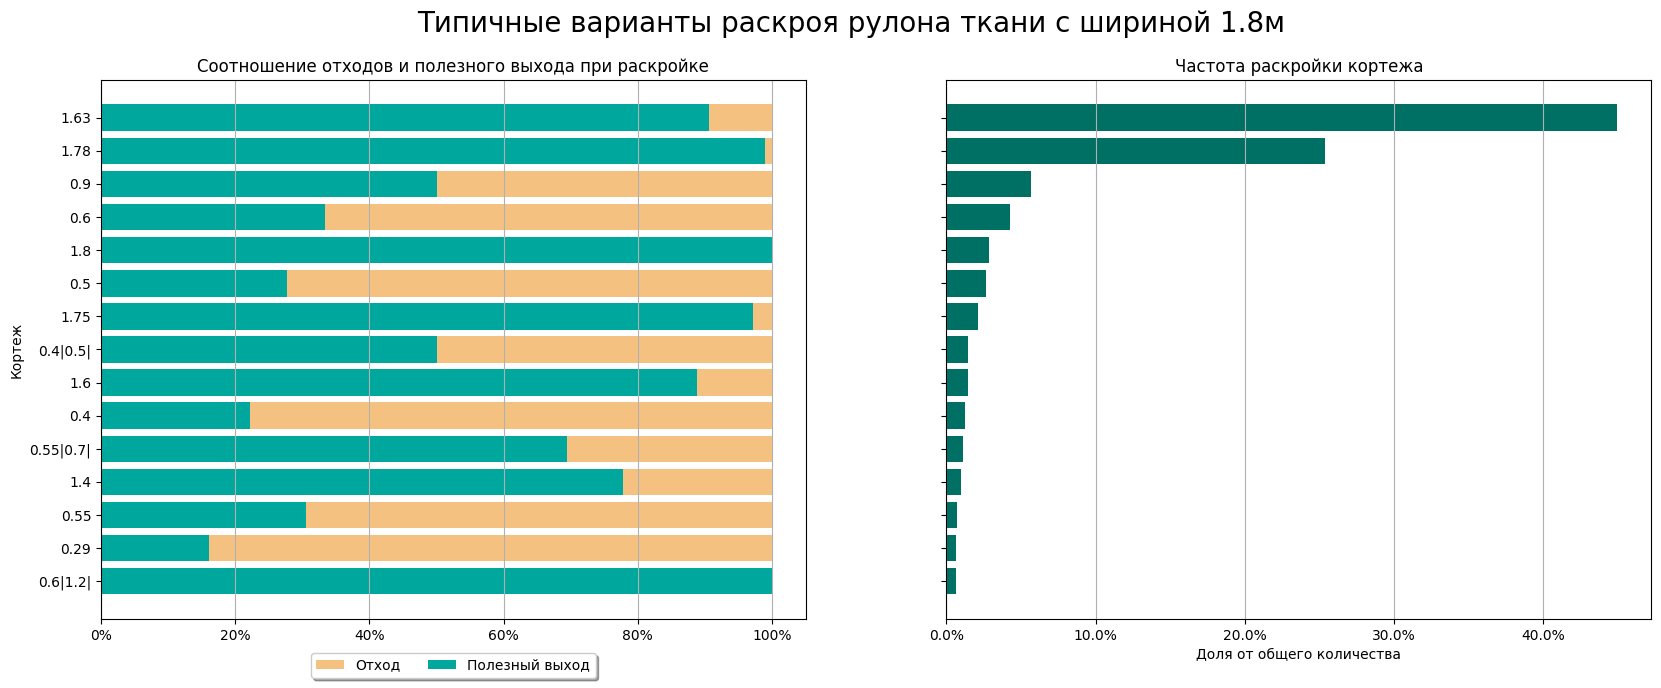

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)

fig.set_figwidth(20)
fig.set_figheight(7)

top = 15
fabric_width = 1.8

axes[0].barh(
    y=fabric_tuples[ fabric_tuples['fabric_width(m)'] == fabric_width ]['slice_tuple'].head(top),
    width=1,
    color='#f5c181',
    label='Отход'
    )
axes[0].barh(
    y=fabric_tuples[ fabric_tuples['fabric_width(m)'] == fabric_width ]['slice_tuple'].head(top),
    width=fabric_tuples[ fabric_tuples['fabric_width(m)'] == fabric_width ]['%_of_valuable'].head(top),
    color='#00a79d',
    label='Полезный выход'
    )

axes[0].set_title('Соотношение отходов и полезного выхода при раскройке')
axes[0].set_xlabel('')
axes[0].set_ylabel('Кортеж')
axes[0].grid(axis='x')
axes[0].invert_yaxis() # обратная сортировка
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


axes[1].barh(
    y=fabric_tuples[ fabric_tuples['fabric_width(m)'] == fabric_width ]['slice_tuple'].head(top), 
    width=fabric_tuples[ fabric_tuples['fabric_width(m)'] == fabric_width ]['%_of_total'].head(top), 
    color='#007065'
    )

axes[1].set_title('Частота раскройки кортежа')
axes[1].set_xlabel('Доля от общего количества')
axes[1].grid(axis='x')
#axes[1].invert_yaxis() # обратная сортировка
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.suptitle('Типичные варианты раскроя рулона ткани с шириной {}м'.format(fabric_width), fontsize=20)
plt.show()

# Graph plot

In [24]:
defect_monthly = footage_production.pivot_table(index='period', values=['defect_m2','produced_m2', 'total_m2'], aggfunc='sum')
defect_monthly['%_of_defect_m2'] = defect_monthly['defect_m2'] / defect_monthly['produced_m2']

defect_monthly.head(3)

,defect_m2,produced_m2,total_m2,%_of_defect_m2
period,,,,
2017-01-01,576.44920,32102.698,33481.10350,0.017956
2017-02-01,193.75650,14580.292,15293.92985,0.013289
2017-03-01,630.43239,29200.164,31072.04376,0.021590


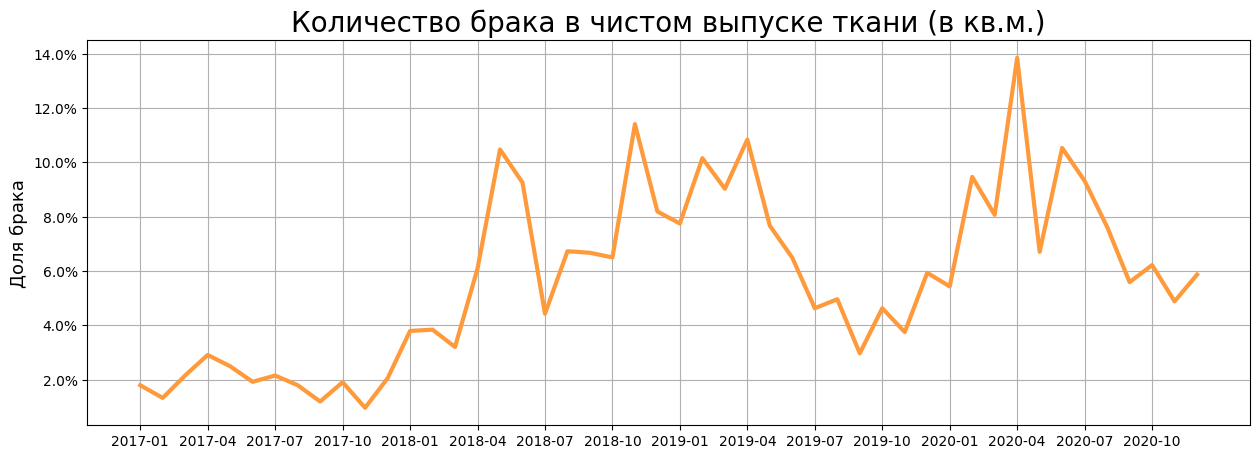

In [25]:
ax = defect_monthly['%_of_defect_m2'].plot(
    figsize=(15,5), 
    grid=True, 
    color='#ff9a3c', 
    linewidth=3
    )

plt.title('Количество брака в чистом выпуске ткани (в кв.м.)', fontsize = 20)
plt.xlabel('', fontsize = 13)
plt.ylabel('Доля брака', fontsize = 13)

# частота по оси Х
frequency = 3
xtick_list = pd.to_datetime(np.array(defect_monthly.index)).strftime('%Y-%m')
plt.xticks(np.arange(defect_monthly.shape[0])[::frequency], xtick_list[::frequency])

# формат оси У
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.show()

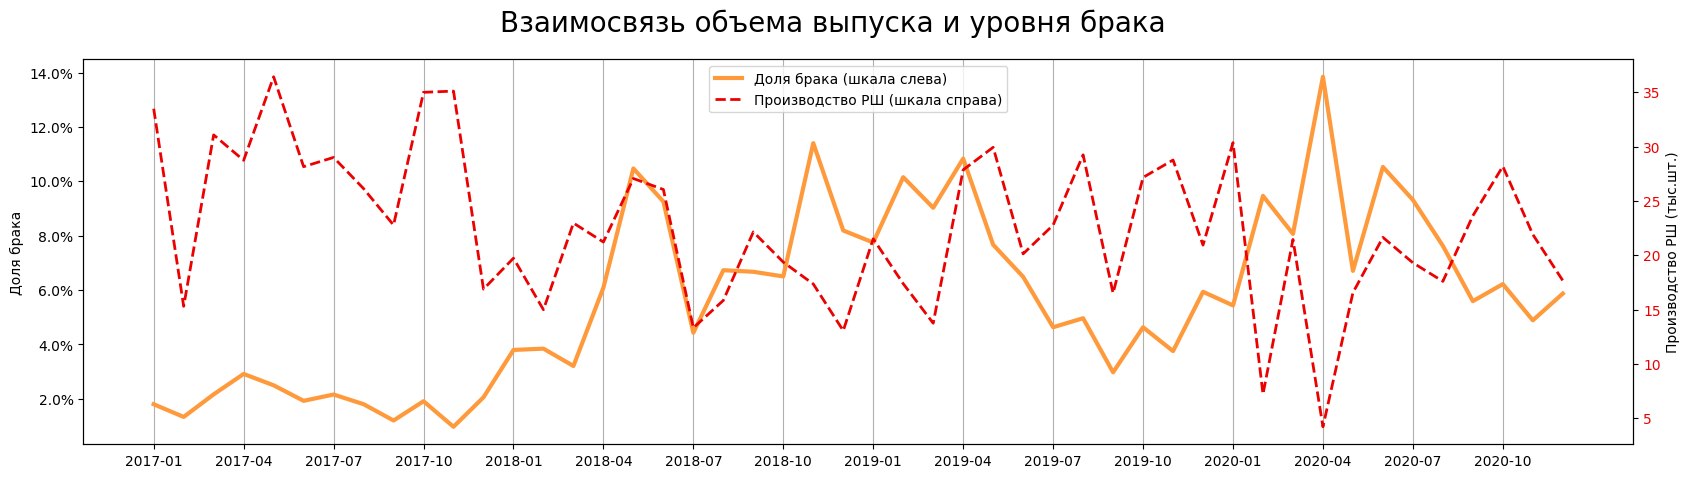

In [26]:
fig, ax1 = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(5)

ax1.plot(
    defect_monthly['%_of_defect_m2'], 
    linewidth=3, 
    color='#ff9a3c', 
    label='Доля брака (шкала слева)'
    )
ax1.set_ylabel('Доля брака')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax1.grid(axis='x')

ax2 = ax1.twinx()
ax2.plot(
    defect_monthly['total_m2']/1000, 
    color='#ec0101', 
    linestyle='dashed', 
    linewidth=2, 
    label='Производство РШ (шкала справа)'
    )
ax2.set_ylabel('Производство РШ (тыс.шт.)')
ax2.tick_params(axis='y', labelcolor='#ec0101')

#fig.tight_layout()

plt.xticks(np.arange(defect_monthly.shape[0])[::frequency], xtick_list[::frequency])
plt.suptitle('Взаимосвязь объема выпуска и уровня брака', fontsize=20)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper center', bbox_to_anchor=(0.5,1))
plt.show()

In [27]:
vgames_year = vgames[ vgames['year_of_release'] > 0 ].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').reset_index()
vgames_year.head(3)

,year_of_release,total_sales
0,1980,11.38
1,1981,35.68
2,1982,28.88


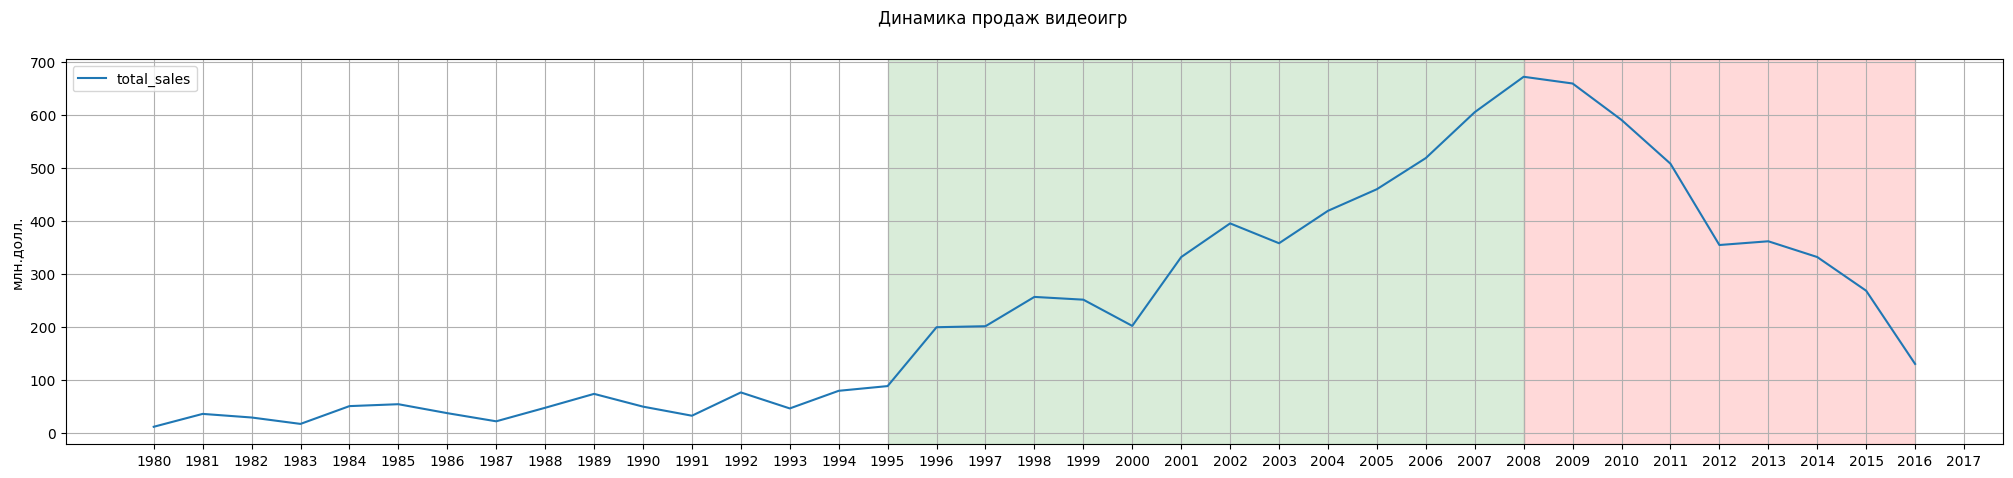

In [28]:
vgames_year.plot(kind='line', x='year_of_release', y='total_sales', figsize=(25,5), grid=True)

plt.xticks(np.arange(1980, 2018, 1))
plt.suptitle('Динамика продаж видеоигр')
plt.ylabel('млн.долл.')
plt.xlabel('')
plt.axvspan(1995, 2008, alpha=0.15, color='green')
plt.axvspan(2008, 2016, alpha=0.15, color='red')
plt.show()

# Scatter plot

In [29]:
defect_density = footage_production[ (footage_production['period'] >= '2019-01-01') & (footage_production['period'] <= '2020-12-01') & (~footage_production['density_g/cm2'].isna()) ]\
    .pivot_table(index=['density_g/cm2','fabric_type'], values=['defect_m2','produced_m2'], aggfunc='sum' )\
    .reset_index()

defect_density['%_of_defect_m2'] = defect_density['defect_m2'] / defect_density['produced_m2']

defect_density.head(3)

,density_g/cm2,fabric_type,defect_m2,produced_m2,%_of_defect_m2
0,110.0,Однотонный,4287.523415,35184.778448,0.121857
1,110.0,Принт,1545.127710,14677.743500,0.105270
2,115.0,Бернаут,43.860000,392.077040,0.111866


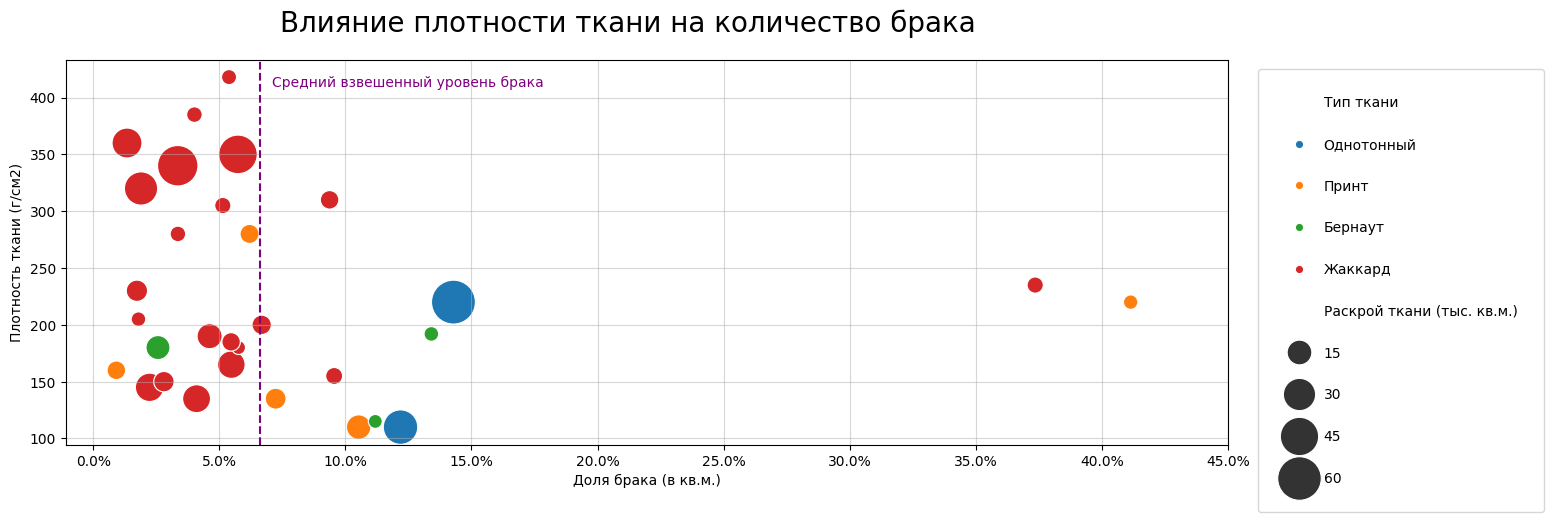

In [30]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(5)

ax = sns.scatterplot(
    x=defect_density['%_of_defect_m2'], 
    y=defect_density['density_g/cm2'],
    hue=defect_density['fabric_type'].rename('Тип ткани'),
    size=defect_density['produced_m2'].rename('Раскрой ткани (тыс. кв.м.)')/1000,
    sizes=(100, 1000)
    )

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.grid(axis='both', alpha=0.5)
ax.set_xlabel('Доля брака (в кв.м.)')
ax.set_ylabel('Плотность ткани (г/см2)')

ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.4), ncol=1, borderpad=1.9, labelspacing=2)

plt.axvline((defect_density['defect_m2'].sum() / defect_density['produced_m2'].sum()), color='purple', alpha=1, linestyle='dashed',label='test')
ax.annotate('Средний взвешенный уровень брака', xy =((defect_density['defect_m2'].sum() / defect_density['produced_m2'].sum())+0.005, 410), color='purple' )

plt.xticks(np.arange(0, 0.5, 0.05))
plt.suptitle('Влияние плотности ткани на количество брака', fontsize=20)
plt.show()

# Heatmap

In [31]:
defect_design_monthly2 = defect_design_monthly.pivot_table(index='period', columns='design_tr', values='%_of_defect_m2').T.fillna(0)
defect_design_monthly2.columns = pd.to_datetime(np.array(defect_design_monthly2.columns)).strftime('%Y-%m')

defect_design_monthly2.head(3)

,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,...,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
design_tr,,,,,,,,,,,,,,,,,,,,,
Бамбук DL,0.000000,0.296403,0.312943,1.016349,0.613665,0.000000,0.894877,0.018591,0.0,0.780796,...,0.0,0.0,0.000000,0.000000,0.182164,3.811968,0.000000,0.180688,0.000000,0.023652
Завитки DL,0.935927,0.000000,0.492895,0.056262,0.000000,0.122043,0.049943,0.253075,0.0,0.000000,...,0.0,0.0,0.058393,1.110766,0.087642,0.000000,0.045839,0.046790,0.001151,2.919059
Кортеза BO,0.251678,0.000000,0.000000,0.015000,0.000000,0.000000,0.000000,0.000000,0.0,0.058777,...,0.0,0.0,0.000000,0.009843,0.484506,0.000000,0.000000,0.352212,0.750854,1.443810


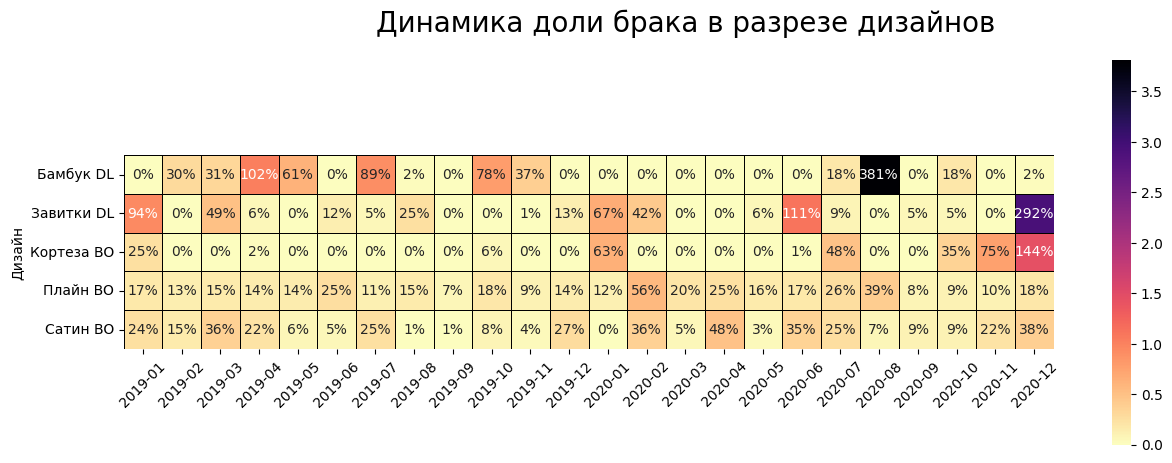

In [32]:
fig, axes = plt.subplots()

fig.set_figwidth(15)
fig.set_figheight(5)

ax = sns.heatmap(
    defect_design_monthly2, 
    annot=True, 
    fmt=".0%", 
    square=True, 
    linecolor='black', 
    linewidths=.4, 
    cmap = 'magma_r', 
    cbar=True)
ax.set_ylabel('Дизайн')
plt.xticks(rotation=45)

plt.suptitle('Динамика доли брака в разрезе дизайнов', fontsize=20)
plt.show()

In [33]:
defect_supplier = footage_production[ (footage_production['period'] >= '2019-01-01') & (footage_production['period'] <= '2020-12-01') ]\
    .pivot_table(index=['supplier','fabric_type'], values=['defect_m2','produced_m2'], aggfunc='sum')\
    .reset_index()

defect_supplier['%_of_defect_m2'] = defect_supplier['defect_m2'] / defect_supplier['produced_m2']
defect_supplier_percent = defect_supplier.pivot_table(index='supplier', columns='fabric_type', values='%_of_defect_m2')
defect_supplier_produced = defect_supplier.pivot_table(index='supplier', columns='fabric_type', values='produced_m2')

defect_supplier_percent.head(3)

fabric_type,Бернаут,Жаккард,Однотонный,Принт
supplier,,,,
Grand Home (Hong Kong) CO. Limited,NaN,NaN,0.272657,0.499973
Hasta Schorling,0.020243,0.070575,0.085441,0.132959
"JOHOF INDUSTRIAL CO., LTD",NaN,NaN,0.150161,0.164092


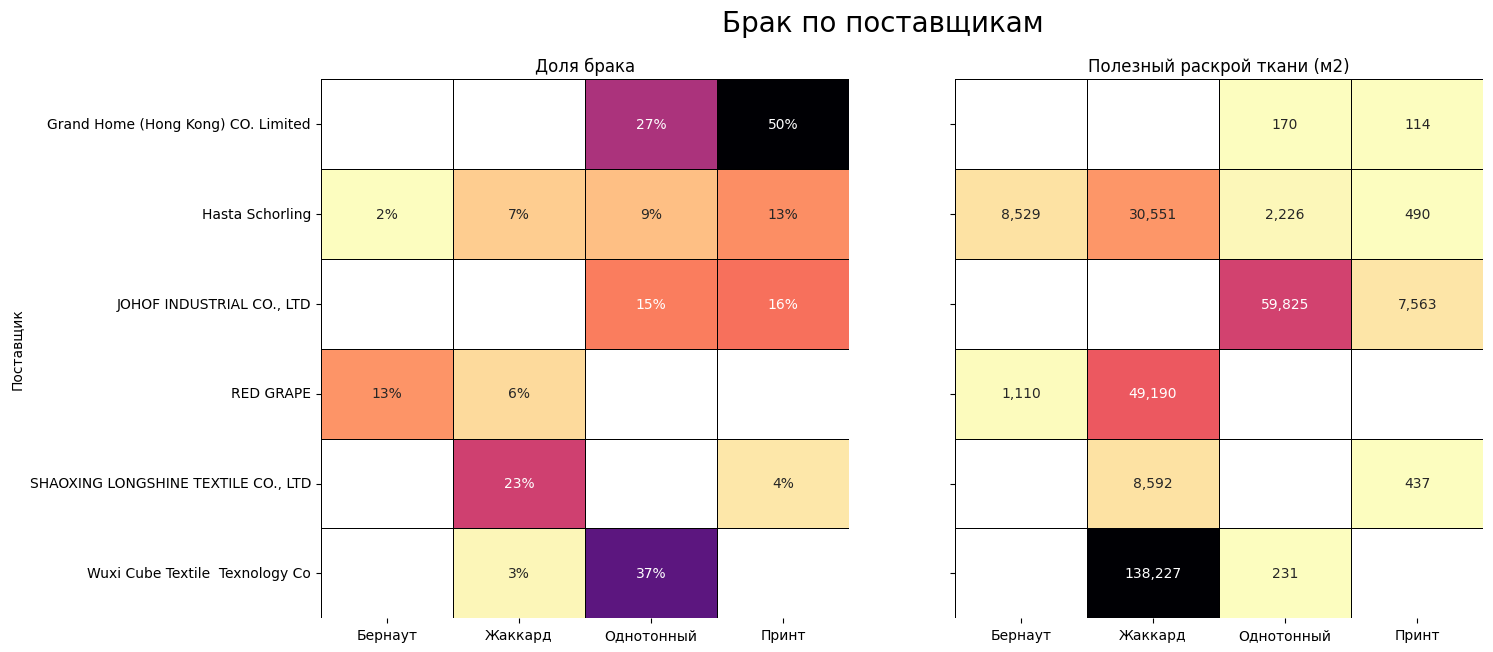

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)

fig.set_figwidth(15)
fig.set_figheight(7)

sns.heatmap(
    defect_supplier_percent, 
    annot=True, 
    fmt=".0%", 
    linecolor='black', 
    linewidths=.4, 
    cmap = 'magma_r', 
    cbar=False,
    ax=axes[0])
axes[0].set_ylabel('Поставщик')
axes[0].set_xlabel('')
axes[0].set_title('Доля брака')


sns.heatmap(
    defect_supplier_produced, 
    annot=True, 
    fmt=",.0f", 
    linecolor='black', 
    linewidths=.4, 
    cmap = 'magma_r', 
    cbar=False,
    ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_title('Полезный раскрой ткани (м2)')

plt.suptitle('Брак по поставщикам', fontsize=20)
plt.show()

# Box plot

In [35]:
defect_batch = footage_production[ 
    (footage_production['period'] >= '2019-01-01') & 
    (footage_production['period'] <= '2020-12-01') & 
    (~footage_production['design'].isna() )
    ]

defect_batch = defect_batch.pivot_table(index=['batch', 'design', 'transparency'], values=['defect_m2','produced_m2'], aggfunc='sum').reset_index()
defect_batch['design_tr'] = defect_batch['design'] + ' ' + defect_batch['transparency']
defect_batch['design_tr'] = defect_batch['design_tr'].str.replace('BLACKOUT','BO')
defect_batch['design_tr'] = defect_batch['design_tr'].str.replace('DAYLIGHT','DL')
defect_batch['%_of_defect_m2'] = defect_batch['defect_m2'] / defect_batch['produced_m2']

defect_batch = defect_batch[ ~defect_batch['batch'].str.contains('Лоскут', case=False) == True ]
defect_batch = defect_batch[ defect_batch['%_of_defect_m2'] <= 1 ]
defect_batch = defect_batch[defect_batch['design_tr'].isin(['Плайн BO', 'Плайн DL', 'Принт (РФ) DL', 'Шантунг DL', 'Шантунг BO', 'Муар BO'])]

defect_batch.head(3)

,batch,design,transparency,defect_m2,produced_m2,design_tr,%_of_defect_m2
0,"00001 (1,65м)",Плайн,BLACKOUT,26.66085,31.0045,Плайн BO,0.859903
1,"00001 (1,65м)",Плайн,DAYLIGHT,8.08500,78.3504,Плайн DL,0.103190
3,"00001 (1,65м)",Принт (РФ),DAYLIGHT,3.13500,24.5361,Принт (РФ) DL,0.127771


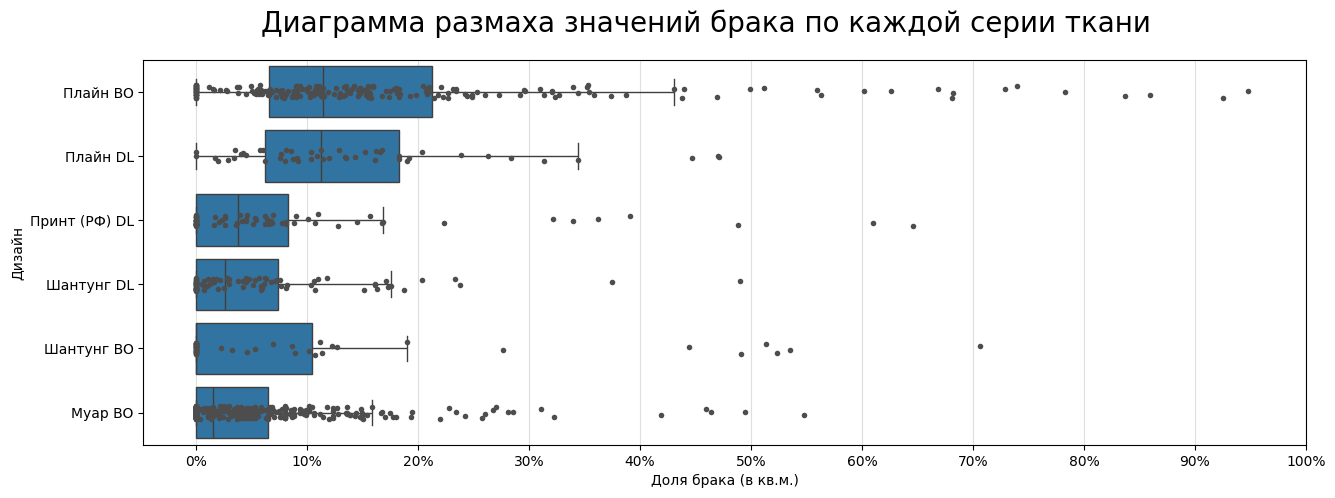

In [36]:
fig, axes = plt.subplots()

fig.set_figwidth(15)
fig.set_figheight(5)

ax1 = sns.boxplot(y='design_tr', x='%_of_defect_m2', data=defect_batch, showfliers=False)
ax2 = sns.stripplot(y='design_tr', x='%_of_defect_m2', data=defect_batch, size=4, color=".3", linewidth=0)

plt.xticks(np.arange(0, 1.1, 0.1))
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.grid(axis='x', alpha=0.4)

ax1.set_xlabel('Доля брака (в кв.м.)')
ax1.set_ylabel('Дизайн')
plt.suptitle('Диаграмма размаха значений брака по каждой серии ткани', fontsize=20)
plt.show()

# Area plot

In [37]:
top_platforms = list(vgames.pivot_table(index='platform', aggfunc='sum', values='total_sales').sort_values(by='total_sales',ascending=False).reset_index().head(10)['platform'])

platform = vgames[(vgames['platform'].isin(top_platforms)) & (vgames['year_of_release'] > 0)].pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
platform.head(3)

platform,DS,GBA,PC,PS,PS2,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,,,,,
1985,0.02,NaN,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,NaN,NaN,3.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN


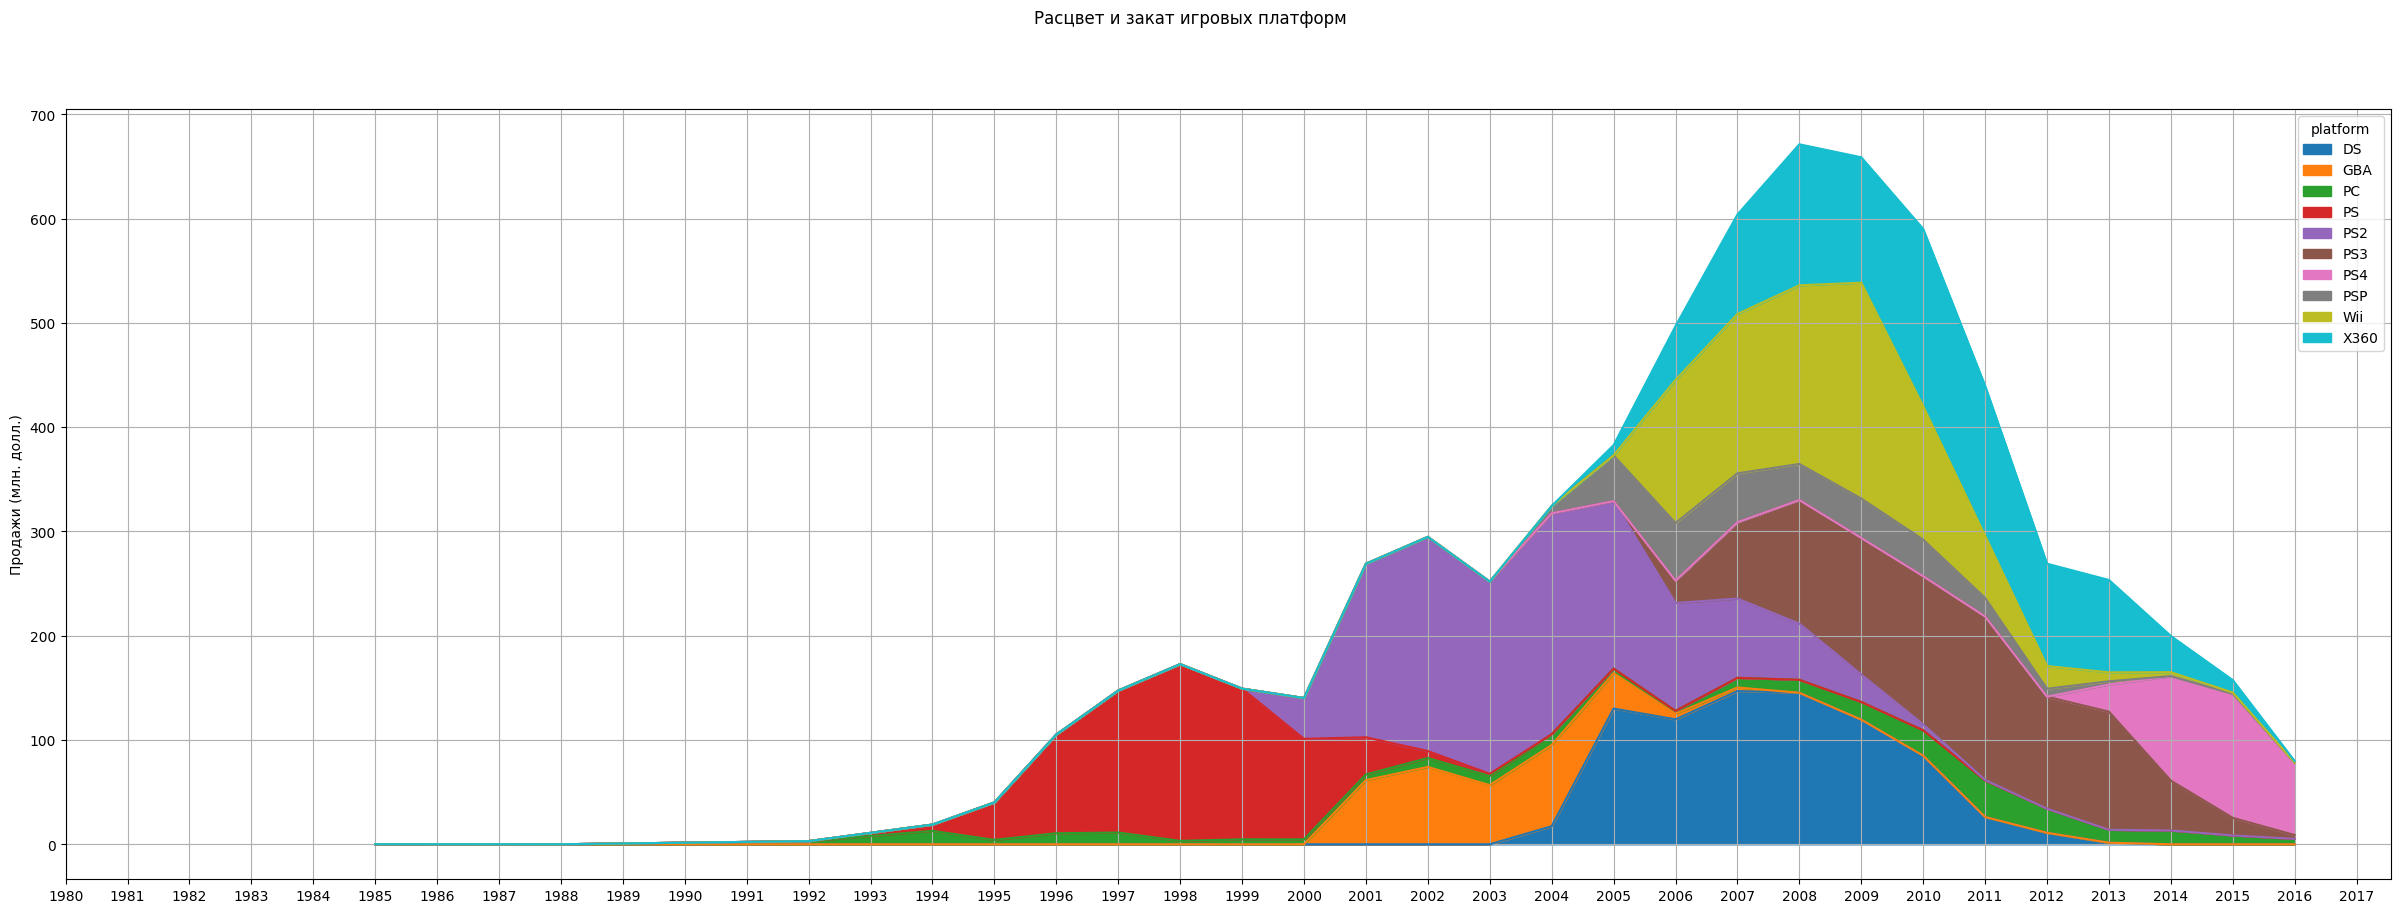

In [38]:
platform.plot.area(figsize=(30,10), grid=True)
plt.xticks(np.arange(1980,2018,1))
plt.suptitle('Расцвет и закат игровых платформ')
plt.ylabel('Продажи (млн. долл.)')
plt.xlabel('')
plt.show()

# Complex plot

In [39]:
stock['date'] = pd.to_datetime(stock['date'], format="%d.%m.%Y")
stock = stock.set_index('date')

stock.head(3)

,open,high,low,close,volume,ticker,30d_ma,90d_ma
date,,,,,,,,
2024-01-02,14873.70,14887.80,14682.38,14765.94,5.791170e+09,NASDAQ Composite,14556.987000,13840.153111
2024-01-03,14641.47,14694.58,14577.44,14592.21,5.449950e+09,NASDAQ Composite,14572.544667,13852.689111
2024-01-04,14532.23,14632.77,14504.78,14510.30,5.289220e+09,NASDAQ Composite,14580.070333,13862.907444


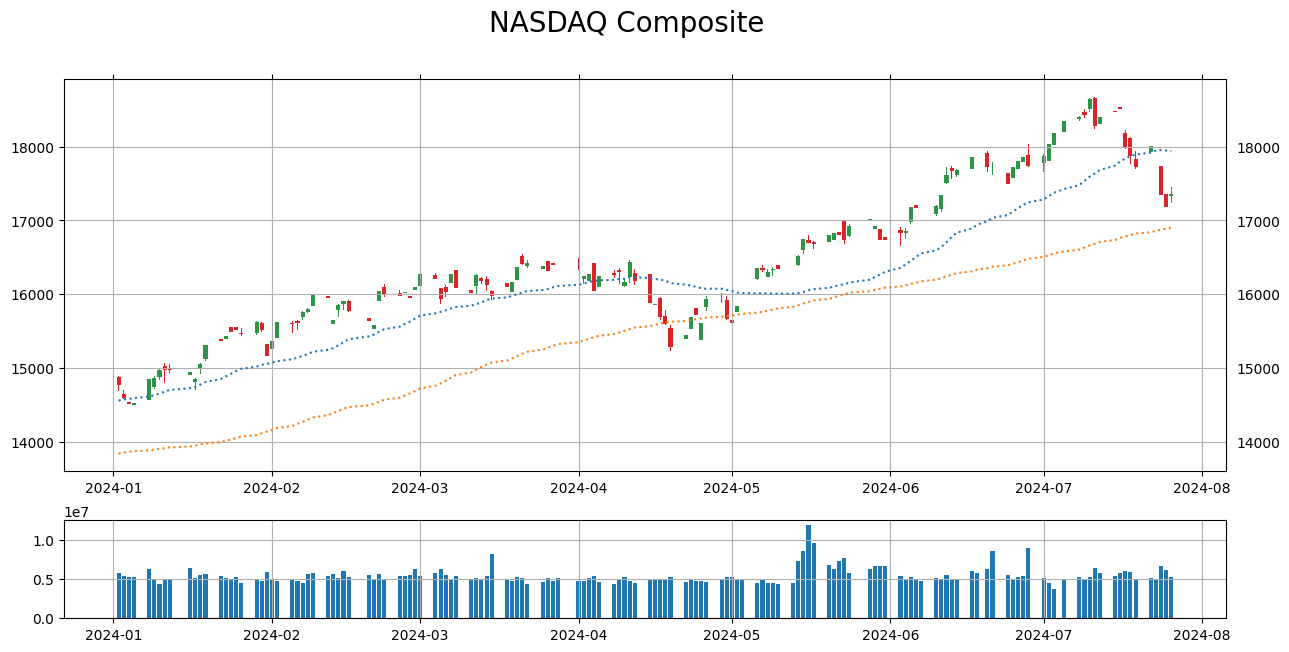

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [4, 1]})

fig.set_figwidth(15)
fig.set_figheight(7)

# Candles (upper plot)
width = 0.8
width2 = 0.1

# define up and down 
up = stock[ stock['close'] >= stock['open'] ]
down = stock[ stock['close'] < stock['open'] ]

# define colors to use
rise = '#2e9448'
fall = '#db2328'

# plot upper candle
ax[0].bar(up.index, up['close']-up['open'], width, bottom=up['open'], color=rise)
ax[0].bar(up.index, up['high']-up['close'], width2, bottom=up['close'], color=rise)
ax[0].bar(up.index, up['low'] - up['open'], width2, bottom=up['open'], color=rise)

# plot lower candle
ax[0].bar(down.index,down['close']-down['open'],width,bottom=down['open'],color=fall)
ax[0].bar(down.index,down['high']-down['open'],width2,bottom=down['open'],color=fall)
ax[0].bar(down.index,down['low']-down['close'],width2,bottom=down['close'],color=fall)

# Rolling mean lines
ax[0].plot(stock['30d_ma'], linestyle=':')
ax[0].plot(stock['90d_ma'], linestyle=':')

# Plot properties
ax[0].xaxis.set_tick_params(rotation=0, reset=True)
ax[0].set_xlabel('')
ax[0].grid(axis='both')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax[0].tick_params(labelright=True)
ax[0].minorticks_off()

# Volumes (lower plot)
ax[1].bar(stock.index, stock['volume']/1000)
ax[1].grid(axis='both')
ax[1].tick_params(axis='x', labelright=True)

plt.suptitle(stock['ticker'].unique()[0], fontsize=20)
plt.show()